In [41]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense
from scipy.interpolate import interp1d
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dropout

# I. Data Loading

In [4]:
# Loading the Monthly Solar Data
file_path = 'solar_data.xlsx'
sheet_name = 'solarbymonth'

# Read the Excel sheet into a Pandas DataFrame
monthly_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract relevant columns
monthly_data['Month'] = pd.to_datetime(monthly_data['Month'])  # Ensure the 'Month' column is in datetime format
months = monthly_data['Month']
utility_gen = monthly_data['Utility Scale Generation']
small_scale_gen = monthly_data['Small Scale Generation']
total_solar = monthly_data['Total Solar']

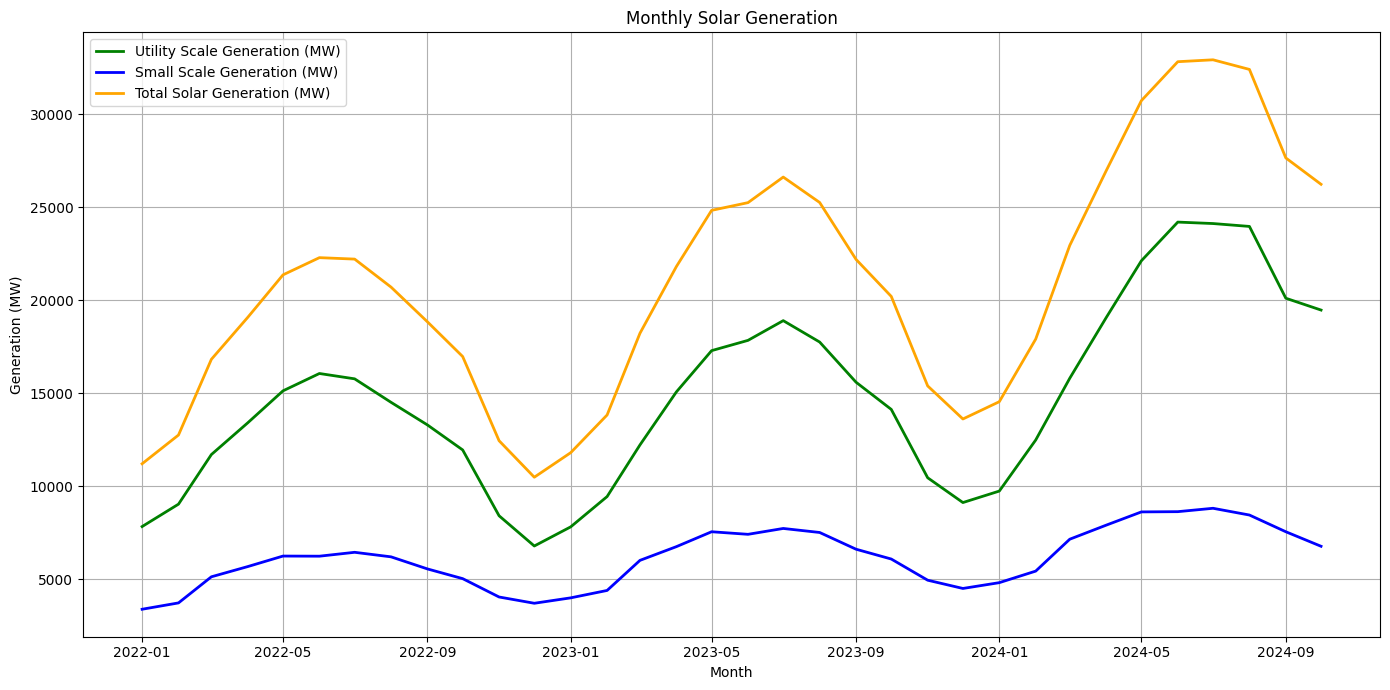

In [5]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(months, utility_gen, label='Utility Scale Generation (MW)', color='green', linewidth=2)
plt.plot(months, small_scale_gen, label='Small Scale Generation (MW)', color='blue', linewidth=2)
plt.plot(months, total_solar, label='Total Solar Generation (MW)', color='orange', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Generation (MW)')
plt.title('Monthly Solar Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
# Loading the TSI Data
data_dir = 'tsi_monthly'

# Find all NetCDF files in the directory
file_paths = sorted(glob(os.path.join(data_dir, 'tsi_*.nc')))

# Initialize an empty list to store DataFrames
data_frames = []

# Loop through each file and load the data
for file_path in file_paths:
    # Open the NetCDF file
    dataset = xr.open_dataset(file_path)
    
    # Convert the dataset to a Pandas DataFrame and reset the index
    df = dataset.to_dataframe().reset_index()
    
    # Ensure the 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Append the DataFrame to the list
    data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)

# Verify loading
print(all_data.head())

        time  bounds          TSI   TSI_UNC  time_bnds
0 2014-01-15       0  1361.692383  0.152830 2014-01-01
1 2014-01-15       1  1361.692383  0.152830 2014-02-01
2 2014-02-15       0  1361.590088  0.173391 2014-02-01
3 2014-02-15       1  1361.590088  0.173391 2014-03-01
4 2014-03-15       0  1362.293213  0.133309 2014-03-01


In [9]:
# Loading the Exponential Regression Data

def exp_func(x, a, b):
    return a * np.exp(b * x)

file_path = 'solar_data.xlsx'
sheet_name = 'capacitygrowth'

# Read the Excel sheet into a Pandas DataFrame
solar_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Sum the residential and commercial annual capacities into small scale
solar_data['Small Scale Annual'] = solar_data['Residential Annual'] + solar_data['Commercial Annual']
solar_data['Small Scale Cumul'] = solar_data['Residential Cumul'] + solar_data['Commercial Cumul']

# Extract relevant columns
years = solar_data['Year']
small_scale_annual = solar_data['Small Scale Annual']
utility_annual = solar_data['Utility Annual']
small_scale_cumul = solar_data['Small Scale Cumul']
utility_cumul = solar_data['Utility Cumul']

# Normalize the years to start from 0 for better numerical stability
normalized_years = years - years.min()

# Perform regression for small scale
params_small, _ = curve_fit(exp_func, normalized_years, small_scale_cumul, maxfev=10000)
small_scale_pred = exp_func(normalized_years, *params_small)

# Perform regression for utility
params_utility, _ = curve_fit(exp_func, normalized_years, utility_cumul, maxfev=10000)
utility_pred = exp_func(normalized_years, *params_utility)

# Verify loading
print(params_small)
print(params_utility)

[2.38570266e+03 2.05533322e-01]
[3.00547527e+03 2.30188812e-01]


# II. ANN Preliminary Testing

In [10]:
# Loading features
tsi_data = all_data.loc[monthly_data.index]
features_utility = pd.DataFrame({'TSI': tsi_data['TSI'],
                                 'Growth Factor': params_utility[1]
                                }, index = monthly_data.index)

# Verify features loading
print(features_utility.head())

           TSI  Growth Factor
0  1361.692383       0.230189
1  1361.692383       0.230189
2  1361.590088       0.230189
3  1361.590088       0.230189
4  1362.293213       0.230189


In [13]:
# Interpolate utility_gen dataset using cubic interpolation for more points to train on
original_index = np.arange(len(utility_gen))
new_index = np.linspace(0, len(utility_gen) - 1, 500) 
cubic_interpolator = interp1d(original_index, utility_gen, kind='cubic')

# Interpolated target data
utility_gen_interpolated = cubic_interpolator(new_index)

# Scale features_utility to match the new length
features_utility_interpolated = pd.DataFrame(
    {
        col: np.interp(new_index, original_index, features_utility[col])
        for col in features_utility.columns
    },
    index=new_index,
)

In [15]:
# Combine the interpolated features and target
X = features_utility_interpolated.values
y = utility_gen_interpolated.reshape(-1, 1)

# Split the data int 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
# Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

In [29]:
# Define the neural network model
def create_nn(n_layers, n_activation, kernels):
    model = tf.keras.models.Sequential()
    for i, nodes in enumerate(n_layers):
        if i == 0:
            model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels, input_dim=X_train.shape[1]))
        else:
            model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels))
    model.add(Dense(1))  # Output layer
    model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [40]:
# Create and summarize the model
nn = create_nn([32, 64], 'relu', 'normal')
nn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
history = nn.fit(X_train, y_train, batch_size=32, epochs=500, validation_data=(X_test, y_test), verbose=2)

Epoch 1/500
13/13 - 1s - 88ms/step - loss: 0.9667 - root_mean_squared_error: 0.9832 - val_loss: 0.9326 - val_root_mean_squared_error: 0.9657
Epoch 2/500
13/13 - 0s - 7ms/step - loss: 0.8963 - root_mean_squared_error: 0.9467 - val_loss: 0.8457 - val_root_mean_squared_error: 0.9196
Epoch 3/500
13/13 - 0s - 7ms/step - loss: 0.8117 - root_mean_squared_error: 0.9009 - val_loss: 0.7568 - val_root_mean_squared_error: 0.8699
Epoch 4/500
13/13 - 0s - 6ms/step - loss: 0.7235 - root_mean_squared_error: 0.8506 - val_loss: 0.7019 - val_root_mean_squared_error: 0.8378
Epoch 5/500
13/13 - 0s - 7ms/step - loss: 0.6743 - root_mean_squared_error: 0.8211 - val_loss: 0.6906 - val_root_mean_squared_error: 0.8310
Epoch 6/500
13/13 - 0s - 5ms/step - loss: 0.6552 - root_mean_squared_error: 0.8094 - val_loss: 0.6841 - val_root_mean_squared_error: 0.8271
Epoch 7/500
13/13 - 0s - 7ms/step - loss: 0.6543 - root_mean_squared_error: 0.8089 - val_loss: 0.6767 - val_root_mean_squared_error: 0.8226
Epoch 8/500
13/13 -

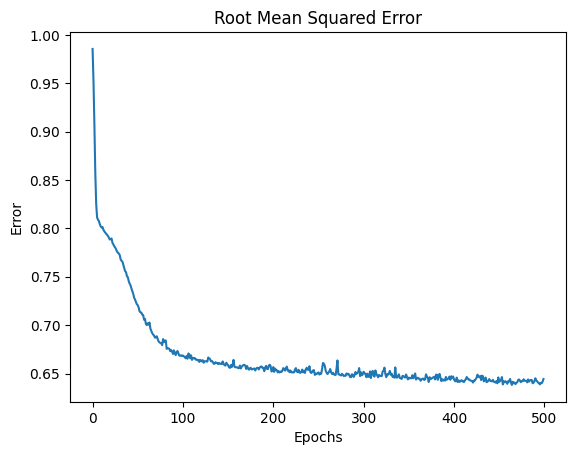

In [21]:
# Plot RMSE over epochs
plt.plot(history.history['root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [22]:
# Evaluate the model
train_rmse = spfnet.evaluate(X_train, y_train, verbose=0)
test_rmse = spfnet.evaluate(X_test, y_test, verbose=0)
print("Train RMSE:", train_rmse[1])
print("Test RMSE:", test_rmse[1])

Train RMSE: 0.6375525593757629
Test RMSE: 0.6844841241836548


In [23]:
# Predict and inverse transform predictions and true values
y_pred = spfnet.predict(X_test)
y_pred_orig = sc_y.inverse_transform(y_pred)
y_test_orig = sc_y.inverse_transform(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [24]:
# Calculate RMSE and R²
rmse = mean_squared_error(y_test_orig, y_pred_orig, squared=False)
r2 = r2_score(y_test_orig, y_pred_orig)
print("Test RMSE (original scale):", rmse)
print("Test R²:", r2)

Test RMSE (original scale): 3290.3428647131195
Test R²: 0.5373637817391252


C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


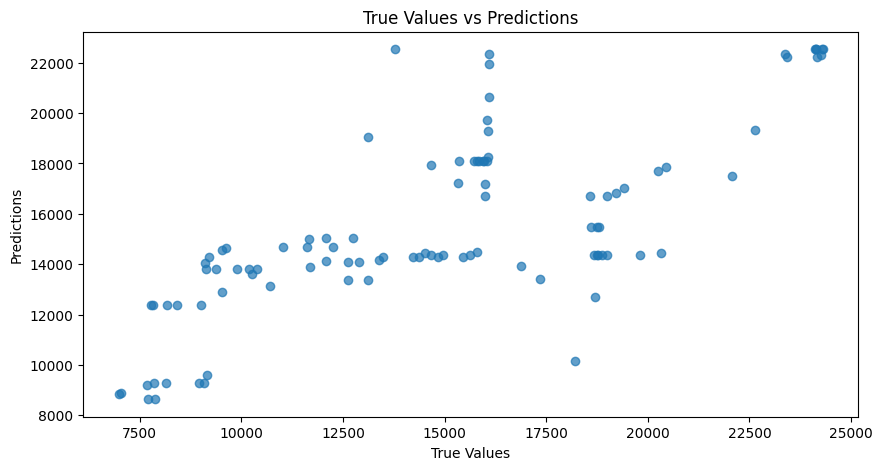

In [25]:
# Visualization: Predictions vs Real Values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.7)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [26]:
# Predictions on the entire dataset
pred_whole = spfnet.predict(sc_X.transform(X))
pred_whole_orig = sc_y.inverse_transform(pred_whole)

# Overall R² score
overall_r2 = r2_score(utility_gen_interpolated, pred_whole_orig)
print("Overall R²:", overall_r2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Overall R²: 0.582210205867663


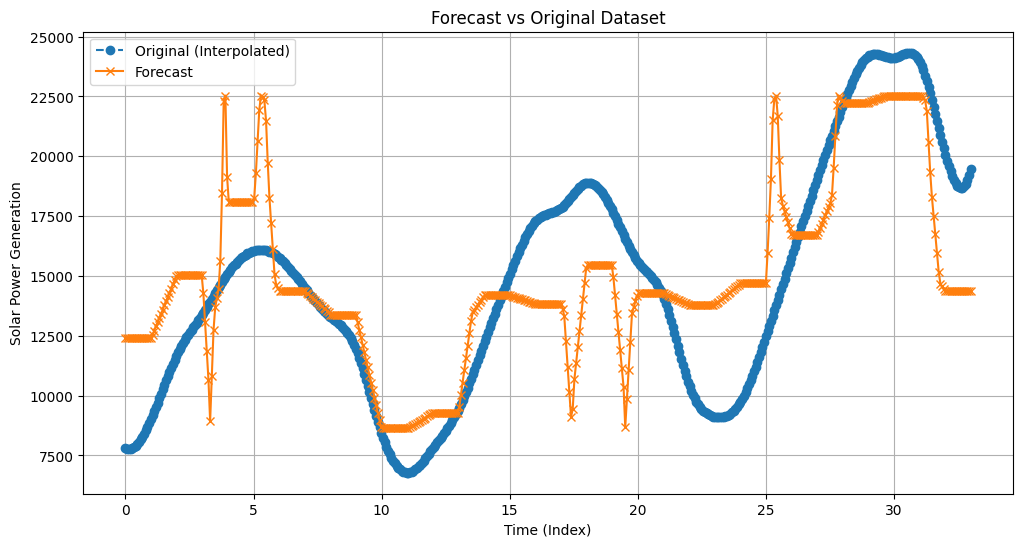

In [27]:
# Plot the original dataset and the forecast
plt.figure(figsize=(12, 6))

# Plot the original interpolated dataset
plt.plot(new_index, utility_gen_interpolated, label='Original (Interpolated)', linestyle='--', marker='o')

# Plot the model's forecast
plt.plot(new_index, pred_whole_orig, label='Forecast', linestyle='-', marker='x')

# Adding labels, legend, and title
plt.xlabel('Time (Index)')
plt.ylabel('Solar Power Generation')
plt.title('Forecast vs Original Dataset')
plt.legend()
plt.grid(True)
plt.show()

### Observations and Discussion
Due to the inaccurate forecasting observed during preliminary testing, the Artificial Neural Network (ANN) was excluded from further testing and implementation. Despite initial expectations of strong predictive capabilities, the ANN model demonstrated higher error rates compared to other approaches.